# Develop implementation of better GPU based cubic interpolation
This notebook shows the development and testing of a python-based implementation of the interpolation scheme described by Præsius et al [1].
In short, this version of the cubic interpolator lets one define the kernel size used in interpolation - whereas Akima interpolation (my current technique) only does a kernel size of at most four points. 
This technique needs at least 4 points.

[1] S. K. Præsius and J. Arendt Jensen, “Fast Spline Interpolation using GPU Acceleration,” in 2024 IEEE Ultrasonics, Ferroelectrics, and Frequency Control Joint Symposium (UFFC-JS), Sep. 2024, pp. 1–5. doi: 10.1109/UFFC-JS60046.2024.10793976.


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

# Make the original and decimated signals, ensuring that the decimated signal still meets the Nyquist criteria

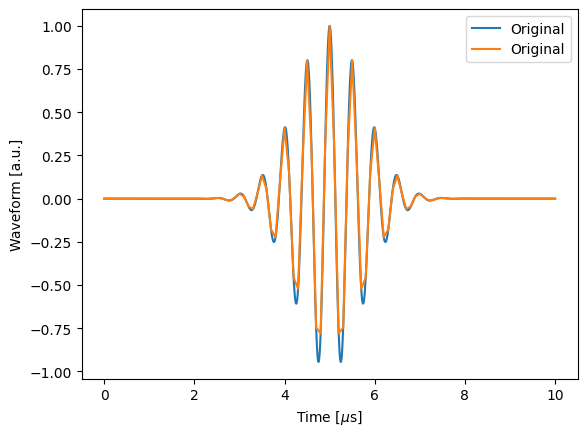

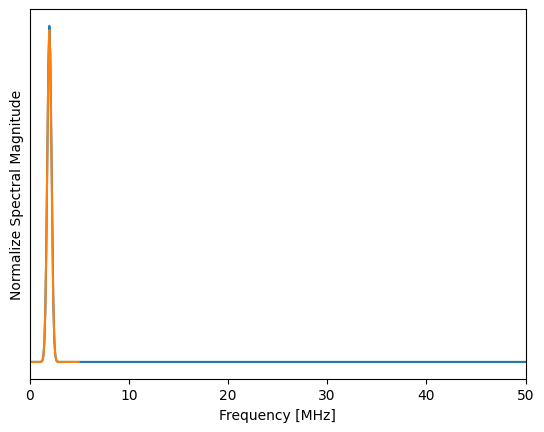

In [57]:
rng = np.random.default_rng(314)
t = np.linspace(0, 10, 1001)
pulse = sig.gausspulse(t=t-5, fc = 2, bw=0.25) #+ rng.normal(0, 0.01, len(t))

t_dec = t[::10]
pulse_dec = pulse[::10]

plt.figure()
plt.plot(t, pulse, label='Original')
plt.plot(t_dec, pulse_dec, label='Original')
plt.legend()
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Waveform [a.u.]")
plt.show()

SPEC = np.abs(np.fft.fftshift(np.fft.fft(pulse)))
FREQ = np.fft.fftshift(np.fft.fftfreq(len(pulse), t[1]-t[0]))

SPEC_DEC = np.abs(np.fft.fftshift(np.fft.fft(pulse_dec)))
FREQ_DEC = np.fft.fftshift(np.fft.fftfreq(len(pulse_dec), t_dec[1]-t_dec[0]))

plt.figure()
plt.plot(FREQ, SPEC, label='Original')
plt.plot(FREQ_DEC, len(t)*SPEC_DEC/len(t_dec), label='Original')
plt.yticks([])
plt.ylabel("Normalize Spectral Magnitude")
plt.xlabel("Frequency [MHz]")
plt.xlim(0,50)
plt.show()

# Make $\mathbf{S}$ matrix that calculates the derivatives of $y$

If $y$ is our length $k$ signal segment, $\vec{y^\prime}$ is the length $k$ vector of derivatives of $\vec{y}$, and $\mathbf{S}$ is a $k$ by $k$ matrix, then

$$\vec{y^\prime} = \mathbf{S} \vec{y},$$

implying that the matrix $\mathbf{S}$ directly calculates the discrete-difference-corrected derivatives along the indices of the vector $\vec{y}$ under the cubic Hermite spline assumptions described in [1].

If you are trying to interpolate between two values of $\vec{y}$, $y_i$ and $y_{i+1}$, you also need the derivatives at the bounding points, $y^\prime_i$ and $y^\prime_{i+1}$.

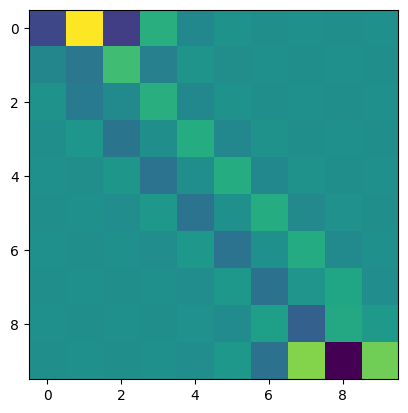

In [58]:
k = 10

def make_S_by_k(k:int):
    # make C matrix
    c_00 = np.ones(k)
    c_00[1:-1] = 4
    c_p1 = np.ones(k-1)
    c_p1[0] = 2
    c_n1 = np.flip(c_p1)

    C  = np.diag(c_00, k= 0)
    C += np.diag(c_p1, k= 1)
    C += np.diag(c_n1, k=-1)

    # make P matrix
    p_p1 = 3*np.ones(k-1)
    p_p1[0] = 2
    p_n1 = -np.flip(p_p1)

    P  = np.diag(p_p1, k= 1)
    P += np.diag(p_n1, k=-1)
    P[0,0] = -2.5
    P[-1,-1] = 2.5
    P[0,2] = 0.5
    P[-1,-3] = -0.5

    return np.linalg.inv(C) @ P

S = make_S_by_k(k)
plt.figure()
plt.imshow(S)
plt.show()

# Make interpolator testing the position of `S` at various points in the recon

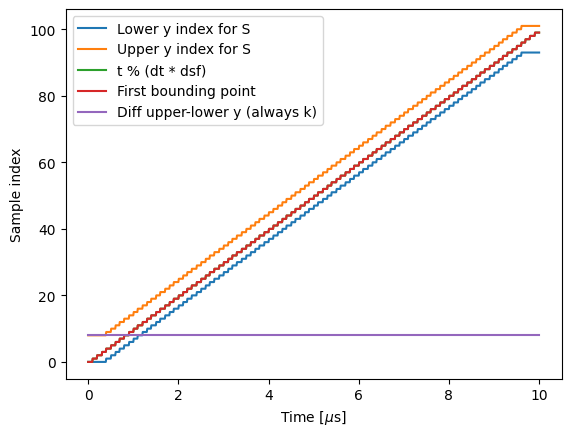

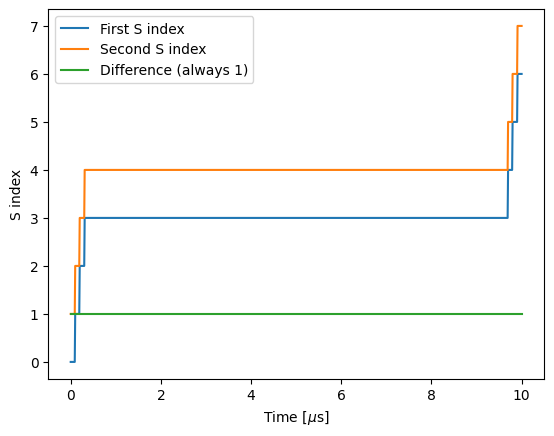

In [59]:
def interp_by_S(x0, dx, nx, yin, xout, S, k, fill=0):

    M = np.array(
        [[ 1,  0,  0,  0],
         [ 0,  0,  1,  0],
         [-3,  3, -2, -1],
         [ 2, -2,  1,  1]]
    )

    pcubic = lambda x: np.array([1, x, x**2, x**3])

    pairs = []
    yout = np.zeros(len(xout))
    if (k < 4) or (k % 2 != 0): raise Exception("k must be greater than or equal to 4 and even")
    for ixo, xo in enumerate(xout):
        if (xo < x0) or (xo > x0 + dx * (nx-1)): 
            yout[ixo] = fill
            continue
        
        ixin = int((xo - x0)//dx)

        if ixin >= nx-1: 
            yout[ixo] = yin[-1]
            continue

        # x1 = x0 + ixin * dx
        # y1 = yin[ixin]
        # y2 = yin[ixin+1]

        if ixin < k//2:
            ik1 = ixin
            ik2 = ixin+1

            iy1 = 0
            iyn = k

        elif ixin > nx - k//2 -1:
            ik1 = k - (nx-ixin)
            ik2 = k - (nx-ixin) + 1

            iy1 = nx-k
            iyn = nx

        else:
            ik1 = (k-1)//2
            ik2 = (k)//2

            iy1 = ixin - (k-1)//2
            iyn = ixin + (k)//2 + 1

        pairs.append((iy1, iyn, ik1, ik2, ixin))

        ypri1 = np.sum(S[ik1] * yin[iy1:iyn])
        ypri2 = np.sum(S[ik2] * yin[iy1:iyn])

        yout[ixo] = pcubic((xo - ixin*dx - x0)/dx) @ M @ np.array([yin[ixin], yin[ixin+1], ypri1, ypri2])
    return pairs, yout

k=8
S = make_S_by_k(k)

pairs, yout = interp_by_S(t_dec[0], t_dec[1]-t_dec[0], len(t_dec), pulse_dec, t, S, k)

pairs = np.array(pairs)

plt.figure()
plt.plot(t, pairs[:,0], label='Lower y index for S')
plt.plot(t, pairs[:,1], label='Upper y index for S')
plt.plot(t, t//t[10], label="t % (dt * dsf)")
plt.plot(t, pairs[:,-1], label="First bounding point")
plt.plot(t, pairs[:,1] - pairs[:,0], label=f"Diff upper-lower y (always k)")
plt.legend()
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Sample index")
plt.show()

plt.figure()
plt.plot(t, pairs[:,2], label="First S index")
plt.plot(t, pairs[:,3], label="Second S index")
plt.plot(t, pairs[:,3] - pairs[:,2], label="Difference (always 1)")
plt.legend()
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("S index")
plt.show()

In [60]:
def interp_by_S(x0, dx, nx, yin, xout, S, k, fill=0):
    yout = np.zeros(len(xout))
    # if (k < 4) or (k % 2 != 0): raise Exception("k must be greater than or equal to 4 and even")
    for ixo, xo in enumerate(xout):
        if (xo < x0) or (xo > x0 + dx * (nx-1)): 
            yout[ixo] = fill
            continue
        
        ixin = int((xo - x0)//dx)

        if ixin >= nx-1: 
            yout[ixo] = yin[-1]
            continue

        # x1 = x0 + ixin * dx
        # y1 = yin[ixin]
        # y2 = yin[ixin+1]

        if ixin < k//2:
            ik1 = ixin
            ik2 = ixin+1

            iy1 = 0
            iyn = k

        elif ixin > nx - k//2 -1:
            ik1 = k - (nx-ixin)
            ik2 = k - (nx-ixin) + 1

            iy1 = nx-k
            iyn = nx

        else:
            ik1 = (k-1)//2
            ik2 = (k)//2

            iy1 = ixin - (k-1)//2
            iyn = ixin + (k)//2 + 1

        ypri1 = np.sum(S[ik1] * yin[iy1:iyn])
        ypri2 = np.sum(S[ik2] * yin[iy1:iyn])

        # yout[ixo] = pcubic((xo - ixin*dx - x0)/dx) @ M @ np.array([yin[ixin], yin[ixin+1], ypri1, ypri2])

        xnorm = (xo - ixin*dx - x0)/dx

        a0 = yin[ixin]
        a1 = ypri1
        a2 = 3 * (yin[ixin+1] - yin[ixin]) - 2 * ypri1 - ypri2
        a3 = 2 * (yin[ixin] - yin[ixin+1]) +     ypri1 + ypri2

        yout[ixo] = a0 + a1 * xnorm + a2 * xnorm * xnorm + a3 * xnorm * xnorm * xnorm
    return yout

In [61]:
rmse = lambda err: np.sqrt(np.mean(err * np.conj(err)).real)

In [62]:
rmses = []
ks = np.arange(4, len(t_dec), 2, dtype=int)
itmin = np.argmin(np.abs(t-3))
itmax = np.argmin(np.abs(t-7))
for k in ks:
    S = make_S_by_k(k)
    pulse_out = interp_by_S(t_dec[0], t_dec[1]-t_dec[0], len(t_dec), pulse_dec, t, S, k)
    rmses.append(rmse(pulse_out[itmin:itmax]-pulse[itmin:itmax]))

In [63]:
20*np.log10(1/0.002)

53.979400086720375

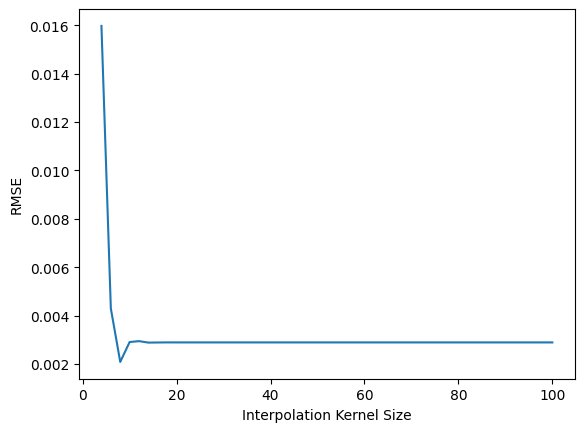

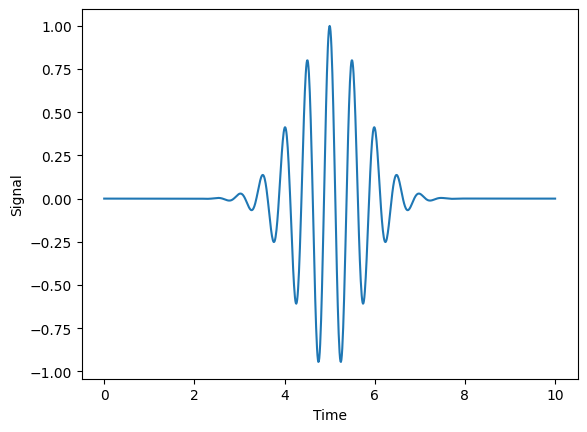

In [64]:
plt.figure()
plt.plot(ks, rmses)
plt.ylabel("RMSE")
plt.xlabel("Interpolation Kernel Size")
plt.show()

plt.figure()
plt.plot(t, pulse)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.show()

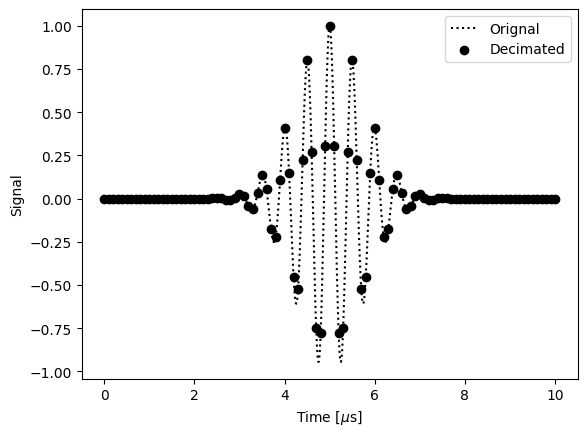

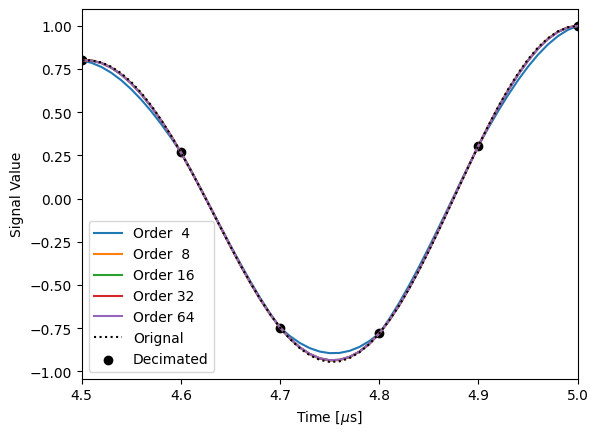

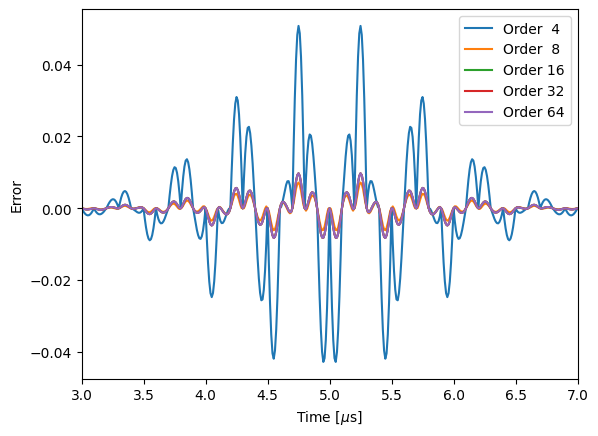

In [65]:
plt.figure()
plt.plot(t, pulse, color='black', linestyle=':', label='Orignal')
plt.scatter(t_dec, pulse_dec, color='black', label='Decimated')
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Signal")
plt.legend()
plt.show()

ks = [4, 8, 16, 32, 64]

pulses_out = {}
for k in ks:
    S = make_S_by_k(k)
    pulses_out[k] = interp_by_S(t_dec[0], t_dec[1]-t_dec[0], len(t_dec), pulse_dec, t, S, k)

plt.figure()
for k in ks:
    plt.plot(t, pulses_out[k], label=f'Order {k:2d}')
plt.plot(t, pulse, color='black', linestyle=':', label='Orignal')
plt.scatter(t_dec, pulse_dec, color='black', label='Decimated')
plt.xlim(4.5, 5)
# plt.ylim(0.2, 1.05)
plt.ylabel("Signal Value")
plt.xlabel("Time [$\\mu$s]")
plt.legend()
plt.show()

plt.figure()
for k in ks: plt.plot(t, pulses_out[k]-pulse, label=f'Order {k:2d}')
plt.legend()
plt.xlim(3, 7)
plt.ylabel("Error")
plt.xlabel("Time [$\\mu$s]")
plt.show()